In [1]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%reload_ext autoreload
%autoreload 2
%aimport bs_eda

In [2]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import bs_eda as beda
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder

## Liste des modifications

1. Pour les variables `mileage` et `price`, convertir les int64 en float64
1. Supprimer les entrées redondantes
1. `price`:
    * Vérifier les valeurs anormales *Z-score*
    * Log pour normaliser la distribution
1. `year`:
    * Supprimer les années excentriques
    * vérifier les voitures avant 2000
1. `mileage`:
    * Traiter la précense d'anomalies dans les valeurs hautes
    * idem valeurs basses
1. `mpg`:
    * Vérifier la validité des valeurs extrêmes, trop basses et trop hautes.
    * Créer une échelle discrète de rendement: bas, moyen, haut
1. `engine_size`
    * Corriger ou supprimer les valeurs 0
    * traiter les valeurs de 6
    * Créer une échelle discrète de taille de moteur: small, large
    * Utiliser un OrdinalEncoder?
1. `tax`
    * Les données apparaissent difficilement fiables, la feature pourrait être supprimée.
1. Variable discrète
    * Encoder les features. LabelEncoder et/ou OneHotEncoder?
1. `transmission`
    * Supprimer les entrées pour lesquelles le mode de transmission est `Other`
1. `fuel_type`
    * Fusionner ou supprimer les catégories de `fuel_type` qui ne sont pas représentatives
1. `model`
    * LabelEncoder

In [3]:
df = pd.read_csv('dataset/train_set.csv', index_col=0)

In [4]:
# Supprimer les entrées redondantes
df.drop_duplicates(inplace = True)

In [5]:
# Pour les variables `mileage` et `price`, convertir les int64 en float64
df['price'] = df['price'].astype(float)
df['mileage'] = df['mileage'].astype(float)

In [6]:
# Vérifier les valeurs anormales *Z-score*
# Log pour normaliser la distribution
columns = beda.get_numerical_columns(df)
thresh = 3
# mask of all rows whose value > thresh
outliers = df[columns].apply(lambda x: np.abs(zscore(x, nan_policy = 'omit')) > thresh).any(axis=1)
# Drop (inplace) rows that match
df.drop(df[columns].index[outliers], inplace = True)

In [7]:
# Year as category
bins=np.arange(df['year'].min()-1,df['year'].max()+2)
print(bins)
#df['year_category']=pd.cut(df['year'],bins=bins)

[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


<AxesSubplot:xlabel='fuel_economy', ylabel='count'>

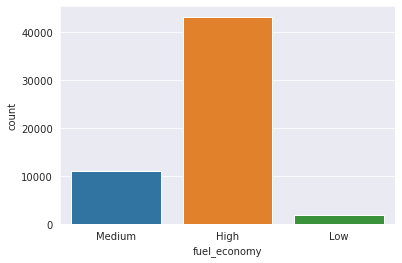

In [204]:
# Créer une échelle discrète de rendement: bas, moyen, haut
def fuel_economy(mpg):
    average = (36,47)
    if mpg<=average[0]: 
        result = "Low"
    if (mpg>average[0] and mpg<average[1]): 
        result = "Medium"
    if mpg>=average[1]: 
        result = "High"
    return result

df["fuel_economy"]=df.apply(lambda x: fuel_economy(x["mpg"]),axis=1)

sns.countplot(data=df,x="fuel_economy")

In [205]:
# Complete engine_size == 0
def replace_by_similar(row, from_data, where_feature, has_cdt_value, using_features):
    x = row.copy()
    if row[where_feature]==has_cdt_value:
        result = beda.get_similar_row(to_this_row=row, in_data=from_data, based_on_cols=cols, show=False)
        if not result.isnull().values.any():
            x[where_feature] = round(result[where_feature].quantile(q=0.75),2)
    return x

feature='engine_size'
search_in_df = df[df[feature]>0]
cols = ['model','transmission', 'fuel_type', 'brand']
df = df.apply(lambda x: replace_by_similar(row=x, from_data=search_in_df, where_feature=feature, 
                                           has_cdt_value=0, using_features=cols), axis=1)

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55949 entries, 3053 to 13349
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype                 
---  ------         --------------  -----                 
 0   model          55949 non-null  object                
 1   year           55949 non-null  int64                 
 2   price          55949 non-null  float64               
 3   transmission   55949 non-null  object                
 4   mileage        55949 non-null  float64               
 5   fuel_type      55949 non-null  object                
 6   tax            55949 non-null  int64                 
 7   mpg            55949 non-null  float64               
 8   engine_size    55949 non-null  float64               
 9   brand          55949 non-null  object                
 10  year_category  55949 non-null  interval[int64, right]
 11  fuel_economy   55949 non-null  object                
dtypes: float64(4), int64(2), interval(1), object(5)
memory us

<AxesSubplot:xlabel='engine_class', ylabel='count'>

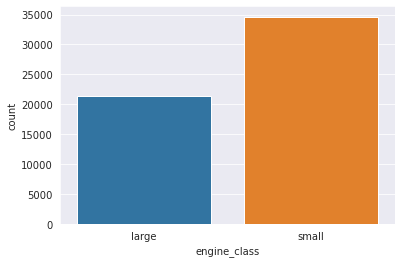

In [207]:
# Créer une échelle discrète de taille de moteur: small, high
def get_engine_class(engine_size):
    if engine_size<2.:
        result = 'small'
    else:
        result = 'large'
    return result

df["engine_class"]=df.apply(lambda x: get_engine_class(x["engine_size"]),axis=1)
sns.countplot(data=df,x="engine_class")

In [208]:
# Complete tax == 0
feature='tax'
search_in_df = df[df[feature]>0]
cols = ['mpg','engine_size']
df = df.apply(lambda x: replace_by_similar(row=x, from_data=search_in_df, where_feature=feature, 
                                           has_cdt_value=0, using_features=cols), axis=1)

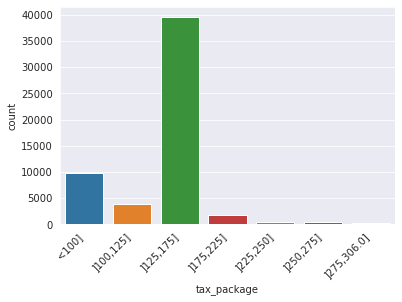

In [209]:
# suppression de `tax` ou
# Créer une échelle discrète de forfait de taxe: small, high
max_tax = df['tax'].max()
bins = [-1,100,125,175,225,250,275,max_tax+1]
labels = []
for i in range(len(bins)-1):
    start = bins[i]
    end = bins[i+1]
    if i==0:
        label = f"<{end}]"
    else:
        label = f"]{start},{end}]" 
    labels.append(label)

df['tax_package']=pd.cut(df['tax'],
                         bins=bins,
                         labels=labels)
figure = sns.countplot(data=df,x="tax_package")
figure.set_xticklabels(figure.get_xticklabels(),rotation=45, horizontalalignment='right')
None

In [210]:
# `transmission`
# Supprimer les entrées pour lesquelles le mode de transmission est `Other`

In [211]:
df = df[df['transmission']!='Other']

In [212]:
# `fuel_type`
# Fusionner ou supprimer les catégories de `fuel_type` qui ne sont pas représentatives
df = df[(df['fuel_type']!='Other')]
df = df[(df['fuel_type']!='Electric')]

In [9]:
# models supprimés par suppression des outliers
unprocessed_data = pd.read_csv('dataset/train_set.csv', index_col=0)
results = unprocessed_data[~unprocessed_data['model'].apply(tuple,1).isin(df['model'].apply(tuple,1))]['model']
print(results.unique())

['Escort' 'Streetka' 'California' 'Fox' 'RS6' 'RS4' 'Q8' 'S8' 'R8' 'SQ7'
 'A2' 'RS7' 'Supra' 'Z3' 'i8' 'i3' 'M5' 'X7' '8 Series' 'M6' 'Accent'
 'Getz' 'Terracan' 'Amica' 'CLK' 'CLC Class' 'G Class' '230' 'R Class'
 'Tigra' 'Vectra' 'Ampera']


In [213]:
df.describe(include='all')

,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,brand,year_category,fuel_economy,engine_class,tax_package
count,55836,55836.000000,55836.000000,55836,55836.000000,55836,55836.000000,55836.000000,55836.000000,55836,55836,55836,55836,55836
unique,162,NaN,NaN,3,NaN,3,NaN,NaN,NaN,9,10,3,2,7
top,Fiesta,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,ford,"(2018, 2019]",High,small,"]125,175]"
freq,3958,NaN,NaN,32527,NaN,31282,NaN,NaN,NaN,10698,14848,43045,34551,39436
mean,NaN,2017.187191,16179.621785,NaN,21898.817967,NaN,127.396572,55.011931,1.632676,NaN,NaN,NaN,NaN,NaN
std,NaN,1.754859,7842.495035,NaN,17827.555381,NaN,50.728203,10.861358,0.487692,NaN,NaN,NaN,NaN,NaN
min,NaN,2011.000000,2395.000000,NaN,1.000000,NaN,10.000000,8.800000,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,2016.000000,10200.000000,NaN,7885.000000,NaN,135.000000,47.100000,1.200000,NaN,NaN,NaN,NaN,NaN
50%,NaN,2017.000000,14450.000000,NaN,17550.500000,NaN,145.000000,55.400000,1.500000,NaN,NaN,NaN,NaN,NaN
75%,NaN,2019.000000,20149.000000,NaN,31656.250000,NaN,145.000000,62.800000,2.000000,NaN,NaN,NaN,NaN,NaN


In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55836 entries, 3053 to 13349
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype                 
---  ------         --------------  -----                 
 0   model          55836 non-null  object                
 1   year           55836 non-null  int64                 
 2   price          55836 non-null  float64               
 3   transmission   55836 non-null  object                
 4   mileage        55836 non-null  float64               
 5   fuel_type      55836 non-null  object                
 6   tax            55836 non-null  float64               
 7   mpg            55836 non-null  float64               
 8   engine_size    55836 non-null  float64               
 9   brand          55836 non-null  object                
 10  year_category  55836 non-null  interval[int64, right]
 11  fuel_economy   55836 non-null  object                
 12  engine_class   55836 non-null  object                
 13

## Generate CSV

In [215]:
directory = 'dataset/'
df.to_csv(join(directory,'train_set_preprocessed.csv'))